In [75]:
import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print('--------------------------------')
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

--------------------------------
--------------------------------
--------------------------------
--------------------------------
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
--------------------------------
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
--------------------------------
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/v

# Importing the necessary libraries

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


In [32]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path): # 지정한 디렉토리 내의 모든 파일과 디렉토리의 이름의 리스트 반환
            print('img', img)
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [33]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

img person1180_virus_2010.jpeg
img person1230_virus_2081.jpeg
img person1513_virus_2632.jpeg
img person124_virus_238.jpeg
img person746_virus_1369.jpeg
img person588_bacteria_2422.jpeg
img person466_virus_960.jpeg
img person1590_bacteria_4175.jpeg
img person399_bacteria_1805.jpeg
img person59_bacteria_279.jpeg
img person57_bacteria_270.jpeg
img person600_bacteria_2456.jpeg
img person1527_virus_2661.jpeg
img person1418_bacteria_3636.jpeg
img person622_bacteria_2494.jpeg
img person1361_bacteria_3476.jpeg
img person494_virus_1000.jpeg
img person97_virus_180.jpeg
img person1689_bacteria_4472.jpeg
img person437_bacteria_1884.jpeg
img person74_bacteria_361.jpeg
img person1338_bacteria_3397.jpeg
img person114_virus_217.jpeg
img person300_bacteria_1421.jpeg
img person1197_virus_2039.jpeg
img person1585_bacteria_4151.jpeg
img person412_bacteria_1827.jpeg
img person318_bacteria_1474.jpeg
img person1519_virus_2646.jpeg
img person332_virus_685.jpeg
img person579_bacteria_2381.jpeg
img person888_vi

In [74]:
# train[0][0] 
train[0][1] # label (0이 PNEUMONIA , 1이 NORMAL)

0

# Data Visualization & Preprocessing

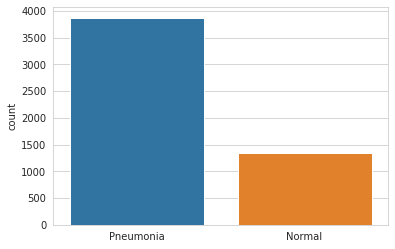

In [76]:
# 데이터 양이 불균형하여 데이터증강이 필요함
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(l)        

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

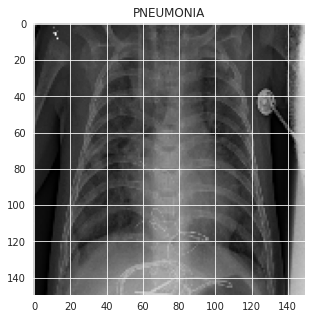

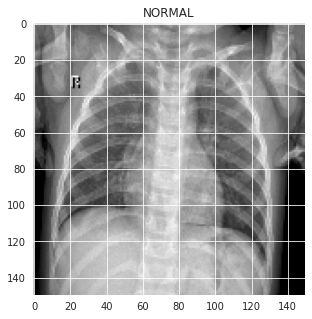

In [29]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [30]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [31]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [37]:
x_train[0][0].shape

(150,)

In [51]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# print('x_train', x_train)
# print('x_train[0]', x_train[0].shape)
print('x_train', x_train.shape)

x_train (5216, 150, 150, 1)


### 데이터 증강

In [52]:
# 데이터 증강
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

In [53]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)       

In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [56]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 14s 88ms/step - loss: 0.5814 - accuracy: 0.8299 - val_loss: 28.5001 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 10s 61ms/step - loss: 0.2791 - accuracy: 0.8905 - val_loss: 52.6307 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 10s 64ms/step - loss: 0.2308 - accuracy: 0.9183 - val_loss: 17.0014 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 10s 61ms/step - loss: 0.1639 - accuracy: 0.9383 - val_loss: 22.9828 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 10s 61ms/step - loss: 0.1500 - accuracy: 0.9457 - val_loss: 10.3849 - val_accuracy: 0.5625
Epoch 6/12
163/163 [==============================] - 10s 63ms/step - loss: 0.1287 - accuracy: 0.9525 - val_loss: 4.1203 - val_accuracy: 0.5625
Epoch 7/12
163/163 [==============================

In [60]:
image_batch, label_batch = next(datagen.flow(x_train,y_train, batch_size = 32))
print(image_batch.shape, label_batch.shape)

(32, 150, 150, 1) (32,)


In [61]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 480us/step
Loss of the model is -  0.3394578381990775
624/624 [==============================] - 0s 462us/step
Accuracy of the model is -  86.21794581413269 %


# Analysis after Model Training

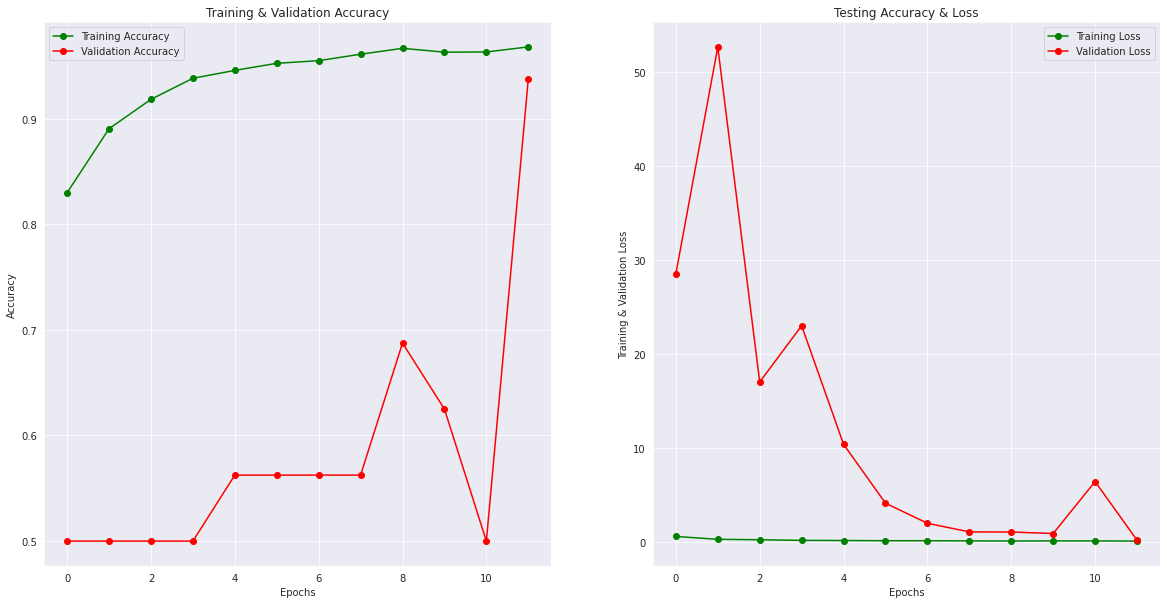

In [62]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [66]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,

In [67]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.82      0.88       390
   Normal (Class 1)       0.76      0.93      0.83       234

           accuracy                           0.86       624
          macro avg       0.85      0.88      0.86       624
       weighted avg       0.88      0.86      0.86       624



In [68]:
cm = confusion_matrix(y_test,predictions)
cm

array([[321,  69],
       [ 17, 217]])

In [69]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

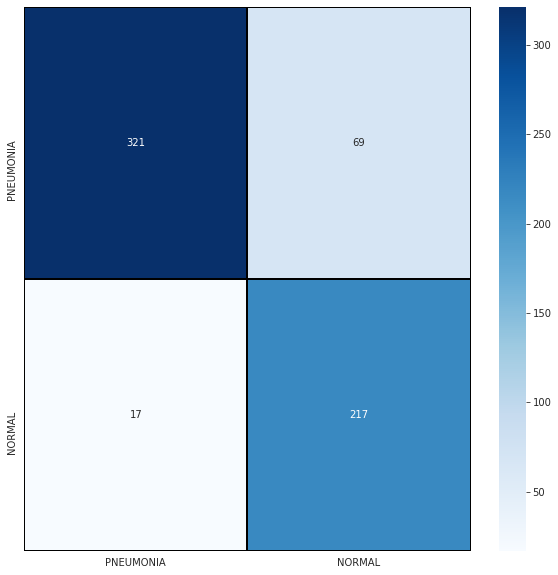

In [70]:
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [71]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

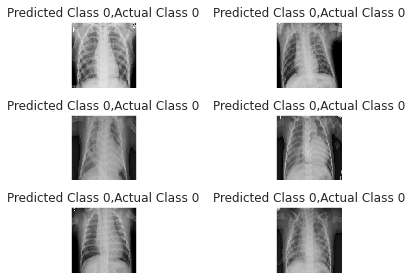

In [72]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

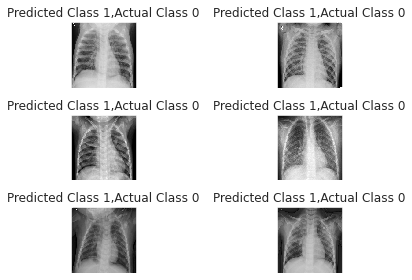

In [73]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1